# First model attempt

https://towardsdatascience.com/time-series-analysis-on-multivariate-data-in-tensorflow-2f0591088502

In [1]:
import sys
sys.path.insert(1, '/Users/lauradellantonio/neuefische/Capstone/capstone')

In [2]:
import pandas as pd
import numpy as np

import functions.functions_data
import functions.functions_mask_wearing
import functions.functions_corona_stats
import functions.functions_HDI
import functions.functions_mask_req

pd.set_option('display.max_columns', None) # To display all columns

import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error

## Reading in and adjusting data

In [3]:
# Reading in survey data and joining it into one dataframe
dfs_country = functions.functions_data.get_data("/Users/lauradellantonio/neuefische/Capstone/capstone/data/CMU_Global_data/Full_Survey_Data/country/smooth/", "country")
countries = pd.concat(dfs_country, ignore_index=True)

Read in data completed.


In [4]:
# Adding the real COVID numbers to the dataframe
covid_cases = pd.read_csv("/Users/lauradellantonio/neuefische/Capstone/capstone/data/Corona_stats/owid-covid-data.csv")
countries = functions.functions_corona_stats.merge_corona_stats(countries,covid_cases)

Merging corona stats completed.


In [5]:
# Sorting out the date column within the dataframe
countries = functions.functions_data.insert_month(countries)

Created month column.


In [6]:
# Dealing with the NaN in the mask wearing column
countries = functions.functions_mask_wearing.deal_with_NaNs_masks(countries)

NaNs before update: 163383
NaNs after update: 0
Updated.


In [7]:
# Getting the dictionaries for the hdi and the hdi-levels.
dict_hdi, dict_hdi_levels = functions.functions_HDI.get_hdi("/Users/lauradellantonio/neuefische/Capstone/capstone/data","hdro_statistical_data_tables_1_15_d1_d5.xlsx")

# Creating a new column with the hdi and the hdi-levels in the regions dataframe
countries = functions.functions_HDI.create_hdi_columns(countries, dict_hdi, dict_hdi_levels)

Creating dictionaries for hdi and hdi-levels completed.
Creating hdi list completed.
Creating hdi-level list completed.


In [8]:
# Adding the mask wearing requirements to the dataframe
mask_wearing_requirements = pd.read_csv("/Users/lauradellantonio/neuefische/Capstone/capstone/data/data-nbhtq.csv")
countries = functions.functions_mask_req.merge_mask_requirements(countries,mask_wearing_requirements)
countries = functions.functions_mask_req.add_requirement_by_date(countries)

Merging mask wearing requirements completed.
Feature engineering completed.


## Selecting relevant columns

In [9]:
df = countries.copy()

In [10]:
# Date used as index

In [11]:
df = df[df["age_bucket"]=="overall"]
df = df[df["gender"]=="overall"]

In [12]:
date = ["date"]

columns_general = ["iso_code", "hdi", "median_age", "aged_65_older", "total_cases_per_million", "new_cases_smoothed_per_million",
                   "total_deaths_per_million", "new_deaths_smoothed_per_million"]

columns_social_distancing = ["smoothed_pct_worked_outside_home_weighted", "smoothed_pct_grocery_outside_home_weighted", "smoothed_pct_ate_outside_home_weighted", 
                             "smoothed_pct_spent_time_with_non_hh_weighted", "smoothed_pct_attended_public_event_weighted", "smoothed_pct_used_public_transit_weighted", 
                             "smoothed_pct_direct_contact_with_non_hh_weighted", "smoothed_pct_no_public_weighted"]

columns_mask_wearing = ["smoothed_pct_wear_mask_all_time_weighted", "smoothed_pct_wear_mask_most_time_weighted", "smoothed_pct_wear_mask_half_time_weighted", 
                        "smoothed_pct_wear_mask_some_time_weighted","smoothed_pct_wear_mask_none_time_weighted"]

columns_mask_req = ["cur_mask_recommended", "cur_mask_required_full_country", "cur_mask_not_required", "cur_mask_not_required_recommended", "cur_mask_not_required_universal", 
                    "cur_mask_required_part_country", "cur_mask_everywhere_in_public", "cur_mask_public_indoors", "cur_mask_public_transport"]

columns_interest = date + columns_general + columns_social_distancing + columns_mask_wearing + columns_mask_req

In [13]:
df_select = df[columns_interest]

In [14]:
df_select.set_index("date", inplace=True)

In [15]:
df_deu = df_select[df_select["iso_code"]=="DEU"]

In [16]:
df_deu.drop("iso_code", axis=1, inplace=True)

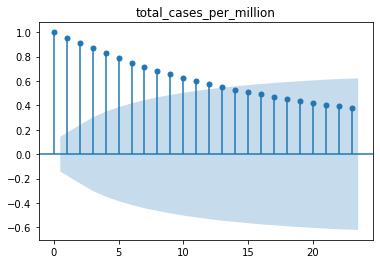

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_deu['total_cases_per_million'])
plt.title('total_cases_per_million')

plt.show()

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

johan_test = df_deu
coint_johansen(johan_test,-1,1).eig

/Users/lauradellantonio/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/vecm.py:577: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn("Critical values are only available for time series "


LinAlgError: Singular matrix

In [44]:
to_scale = ["total_cases_per_million", "new_cases_smoothed_per_million", "total_deaths_per_million", 
            "new_deaths_smoothed_per_million","smoothed_pct_worked_outside_home_weighted", "smoothed_pct_grocery_outside_home_weighted", 
            "smoothed_pct_ate_outside_home_weighted", "smoothed_pct_spent_time_with_non_hh_weighted", 
            "smoothed_pct_attended_public_event_weighted", "smoothed_pct_used_public_transit_weighted", 
            "smoothed_pct_direct_contact_with_non_hh_weighted", "smoothed_pct_no_public_weighted", 
            "smoothed_pct_wear_mask_all_time_weighted", "smoothed_pct_wear_mask_most_time_weighted", 
            "smoothed_pct_wear_mask_half_time_weighted", "smoothed_pct_wear_mask_some_time_weighted",
            "smoothed_pct_wear_mask_none_time_weighted"]

In [45]:
#scale the values
scaler = MinMaxScaler()
df_deu[to_scale] = scaler.fit_transform(df_deu[to_scale])

In [58]:
#divide the data into train and test data
train_size = int(len(df_deu) * 0.80)
test_size = len(df_deu) - train_size
train, test = df_deu[0:train_size], df_deu[train_size:len(df_deu)]

In [65]:
#index the data into dependent and independent variables
train_X, train_y = train.drop("total_cases_per_million", axis=1), train["total_cases_per_million"]
test_X, test_y =  test.drop("total_cases_per_million", axis=1), test["total_cases_per_million"]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(152, 28) (152,) (38, 28) (38,)


In [69]:
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values

In [70]:
#convert data into suitable dimension for using it as input in LSTM network
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(152, 1, 28) (152,) (38, 1, 28) (38,)


Epoch 1/250
3/3 - 0s - loss: 0.2291 - val_loss: 0.2529
Epoch 2/250
3/3 - 0s - loss: 0.2250 - val_loss: 0.2556
Epoch 3/250
3/3 - 0s - loss: 0.1898 - val_loss: 0.4847
Epoch 4/250
3/3 - 0s - loss: 0.1769 - val_loss: 0.3736
Epoch 5/250
3/3 - 0s - loss: 0.1644 - val_loss: 0.2172
Epoch 6/250
3/3 - 0s - loss: 0.2214 - val_loss: 0.2315
Epoch 7/250
3/3 - 0s - loss: 0.2091 - val_loss: 0.4263
Epoch 8/250
3/3 - 0s - loss: 0.1667 - val_loss: 0.4926
Epoch 9/250
3/3 - 0s - loss: 0.1526 - val_loss: 0.3577
Epoch 10/250
3/3 - 0s - loss: 0.1381 - val_loss: 0.2570
Epoch 11/250
3/3 - 0s - loss: 0.1753 - val_loss: 0.3058
Epoch 12/250
3/3 - 0s - loss: 0.1775 - val_loss: 0.4176
Epoch 13/250
3/3 - 0s - loss: 0.1528 - val_loss: 0.4417
Epoch 14/250
3/3 - 0s - loss: 0.1422 - val_loss: 0.3501
Epoch 15/250
3/3 - 0s - loss: 0.1536 - val_loss: 0.2778
Epoch 16/250
3/3 - 0s - loss: 0.1731 - val_loss: 0.3237
Epoch 17/250
3/3 - 0s - loss: 0.1296 - val_loss: 0.4423
Epoch 18/250
3/3 - 0s - loss: 0.1373 - val_loss: 0.4572
E

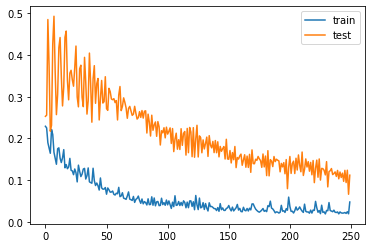

In [71]:
model = Sequential()
model.add(LSTM(250, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=250, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [72]:
#prediction on training and testing data
train_predict = model.predict(train_X)    
test_predict = model.predict(test_X)       

#converting from three dimension to two dimension
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_train_predict = concatenate((train_predict, train_X), axis=1)
inv_test_predict = concatenate((test_predict, test_X), axis=1)

#transforming to original scale
inv_train_predict = scaler.inverse_transform(inv_train_predict)
inv_test_predict = scaler.inverse_transform(inv_test_predict)

#predicted values on training data
inv_train_predict = inv_train_predict[:,0]
inv_train_predict

#predicted values on testing data
inv_test_predict = inv_test_predict[:,0]
inv_test_predict 

ValueError: operands could not be broadcast together with shapes (152,29) (17,) (152,29) 